In [101]:
from random import random

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from transformers import GPT2Config, GPT2LMHeadModel
import matplotlib.pyplot as plt
from functions import *
from CONSTANTS import *
from sklearn.model_selection import train_test_split, TimeSeriesSplit

In [127]:
class LLM(nn.Module):
    def __init__(self, inputSize, hiddenSize, layers):
        super(LLM, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Linear(inputSize, hiddenSize)
        
        # Hidden layers with attention
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hiddenSize, hiddenSize) for _ in range(layers)
        ])
        
        # Attention mechanisms
        self.attention_weights = nn.ModuleList([
            nn.Linear(hiddenSize, 1) for _ in range(layers)
        ])
        
        # Output layer
        self.output = nn.Linear(hiddenSize, 1)
        
        # Activation
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0)
        
    def forward(self, x):
        # Initial embedding
        x = self.activation(self.embedding(x))
        
        attention_scores = []
        
        # Process through hidden layers with attention
        for i, (layer, attention) in enumerate(zip(self.hidden_layers, self.attention_weights)):
            # Calculate attention weights
            attn = torch.softmax(attention(x), dim=1)
            attention_scores.append(attn)
            
            # Apply attention weights
            x = layer(x) * attn
            x = self.activation(x)
            x = self.dropout(x)
            
        # Final output
        output = self.output(x)
        
        # Store attention scores for inspection
        self.last_attention_scores = attention_scores
        
        return output
        
    def get_attention_weights(self):
        """Return the attention weights from the last forward pass"""
        return self.last_attention_scores

# Sample

input shape: torch.Size([4, 5])
target shape: torch.Size([4, 1])
Early Stopping at Epoch 756
Predicted next number: 10.34


Text(0, 0.5, 'MSE')

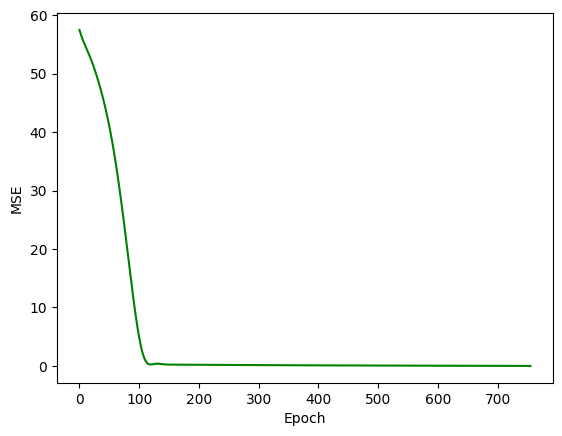

In [121]:
# Initialize the model
input_size = 5  # Number of previous numbers in the sequence
hidden_size = 128
num_layers = 3
model = LLM(input_size, hidden_size, num_layers)
lossFunction = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
data = [
    ([1, 2, 3, 4, 5], 6),
    ([2, 3, 4, 5, 6], 7),
    ([3, 4, 5, 6, 7], 8),
    ([4, 5, 6, 7, 8], 9),
]

# Convert data to tensors
inputs = torch.tensor([item[0] for item in data], dtype=torch.float32)
targets = torch.tensor([item[1] for item in data], dtype=torch.float32).unsqueeze(1)
print('input shape:', inputs.shape)
print('target shape:', targets.shape)

# Training loop
epochs = 1000
losses = []
for epoch in range(epochs):
    # Forward pass
    predictions = model(inputs)
    loss = lossFunction(predictions, targets)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss = loss.item()
    losses.append(loss)
    if loss < 1e-2:
        print(f'Early Stopping at Epoch {epoch+1}')
        break

# Test the model
test_input = torch.tensor([[5, 6, 7, 8, 9]], dtype=torch.float32)
predicted_output = model(test_input).item()
print(f"Predicted next number: {predicted_output:.2f}")
pd.Series(losses).plot(color='green')
plt.xlabel('Epoch')
plt.ylabel('MSE')

# Try the NN for the full data

Preprocess bitcoin data

In [128]:
data = setup('BTC')[0]
data.set_index('time', inplace=True, drop=True)
data

,low,high,open,close,volume,change,pct_change,SMA_20,SMA_50,EMA_20,...,Username,Text,Created_at,Tweet_ID,coin,sentiment_tweet_roberta,score_filtered,date_filtered,gradient,TextType
time,,,,,,,,,,,,,,,,,,,,,
2024-04-18,60816.07,64210.00,61275.73,63513.85,15249.842114,2238.12,3.652539,63384.6340,65477.6480,64040.801175,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,tweet
2024-04-19,59573.32,65498.99,63514.84,63848.37,22838.079342,333.53,0.525121,63267.4180,65593.8616,64096.269720,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,334.52,tweet
2024-04-20,63121.15,65463.08,63841.96,64968.87,5157.407265,1126.91,1.765156,63228.6780,65702.9752,64122.364427,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1120.50,newspaper
2024-04-21,64250.00,65725.81,64960.82,64952.92,4487.487232,-7.90,-0.012161,63019.6080,65796.3552,64033.258577,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-15.95,tweet
2024-04-22,64520.00,67272.73,64952.92,66859.17,10977.051786,1906.25,2.934818,62812.6935,65887.2514,63936.452112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1906.25,tweet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-16,83088.02,85526.40,83622.52,84028.72,8243.059013,406.20,0.485754,65573.5735,66024.8888,67770.072844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,newspaper
2025-04-16,83088.02,85526.40,83622.52,84028.72,8243.059013,406.20,0.485754,65573.5735,66024.8888,67770.072844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,newspaper
2025-04-16,83088.02,85526.40,83622.52,84028.72,8243.059013,406.20,0.485754,65573.5735,66024.8888,67770.072844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,newspaper


In [129]:
sequences = []
for i in range(len(data)-1):
    # create a sequence of all the previous values followed by the next one
    # to be separated into different columns at the bottom
    sequences.append(sequence(data['gradient'], i))

last = data['gradient'].values.tolist() # address the last value
item = (last, 0)
sequences.append(item)

# add it to the data and separate
# padding required to make it go through
data['list'] = [i[0] for i in sequences]
data['list'] = data['list'].apply(lambda a: padding(a, len(data)))
data['next'] = [i[1] for i in sequences]
data[['gradient', 'list', 'next']]

,gradient,list,next
time,,,
2024-04-18,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",334.52
2024-04-19,334.52,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1120.50
2024-04-20,1120.50,"[0.0, 334.5200000000041, 0.0, 0.0, 0.0, 0.0, 0...",-15.95
2024-04-21,-15.95,"[0.0, 334.5200000000041, 1120.5, 0.0, 0.0, 0.0...",1906.25
2024-04-22,1906.25,"[0.0, 334.5200000000041, 1120.5, -15.950000000...",-445.01
...,...,...,...
2025-04-16,0.00,"[0.0, 334.5200000000041, 1120.5, -15.950000000...",0.00
2025-04-16,0.00,"[0.0, 334.5200000000041, 1120.5, -15.950000000...",0.00
2025-04-16,0.00,"[0.0, 334.5200000000041, 1120.5, -15.950000000...",0.00


### Fit the model on the list and next

Preprocessing & Train Test Split

In [134]:
TRAIN_PCT = 0.8
X = data[['list']]
y = data['next']

tscv = TimeSeriesSplit(n_splits=5)
splits = tscv.split(X)
X_trains = []
y_trains = []
X_tests = []
y_tests = []
for train_index, test_index in splits:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_tests.append(X_test)
    y_tests.append(y_test)

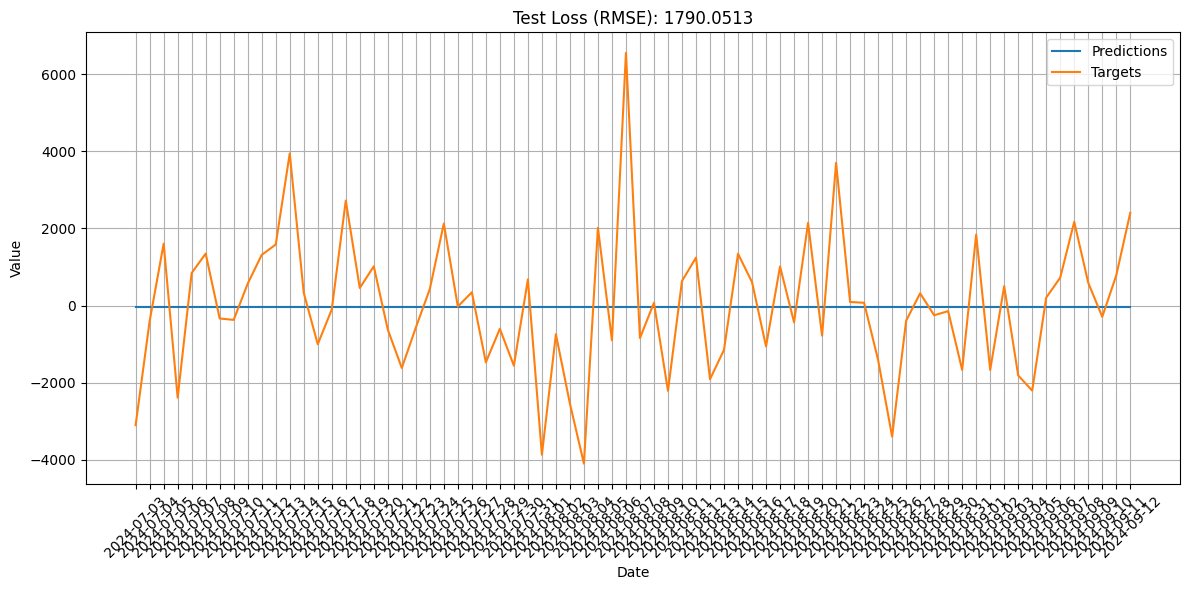

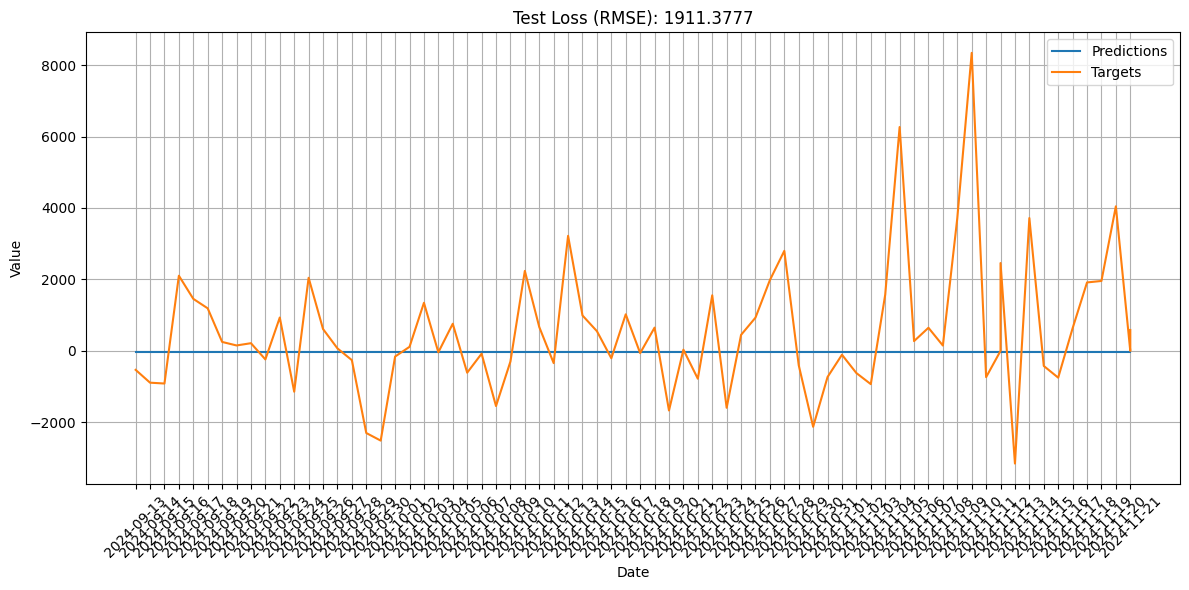

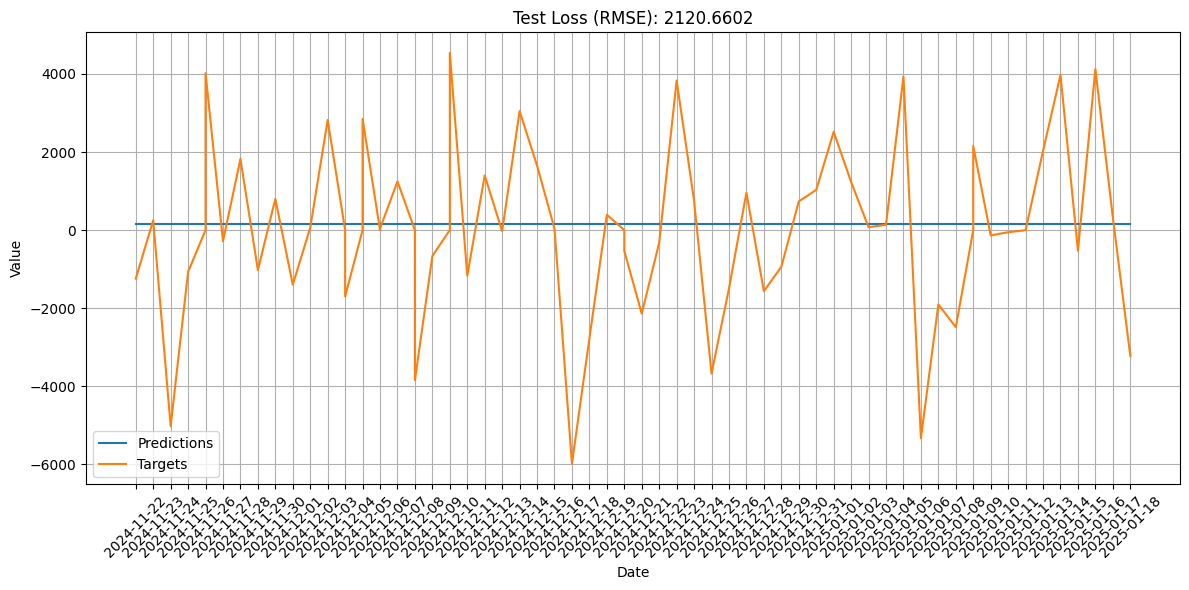

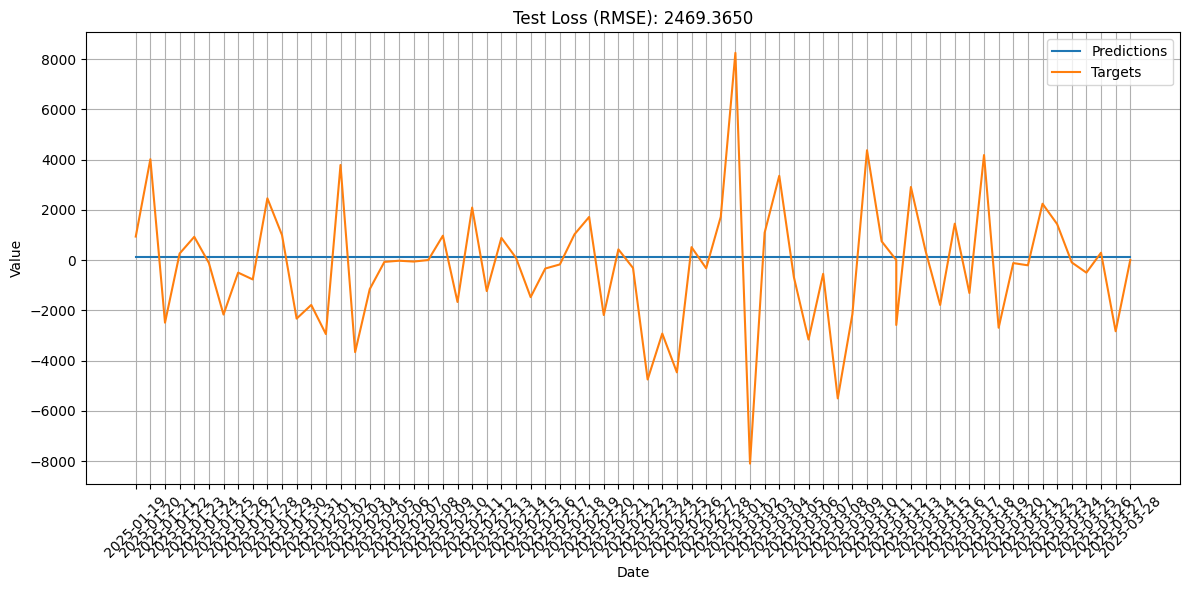

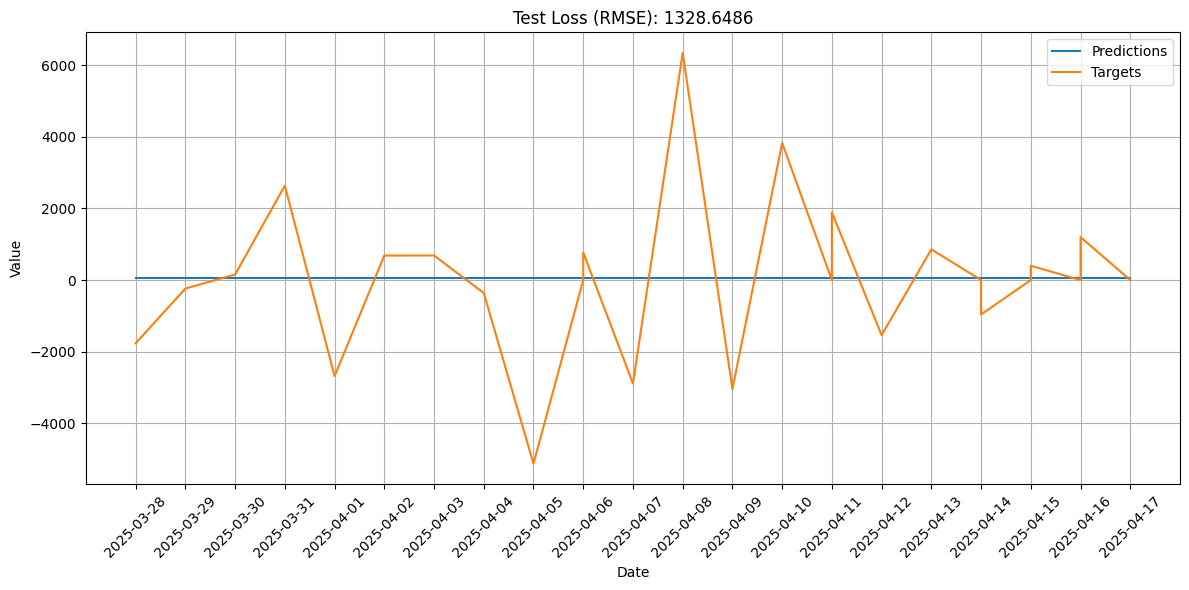

In [143]:
# inputs = torch.tensor(X_train['list'].tolist(), dtype=torch.float32)
# targets = torch.tensor(y_train.tolist(), dtype=torch.float32).unsqueeze(1)

metrics = []
EPOCHS = 5000
NUM_LAYERS = 80
HIDDEN_SIZE = 128
for X_train, X_test, y_train, y_test in zip(X_trains, X_tests, y_trains, y_tests):
    inputs = torch.tensor(X_train['list'].tolist(), dtype=torch.float32)
    targets = torch.tensor(y_train.tolist(), dtype=torch.float32).unsqueeze(1)
    input_size = len(X_train['list'].tolist()[0])
    model = LLM(input_size, HIDDEN_SIZE, NUM_LAYERS)
    lossFunction = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    epochs = 100
    losses = []
    for epoch in range(EPOCHS):
        # Forward pass
        predictions = model(inputs)
        loss = lossFunction(predictions, targets) ** 0.5 # RMSE

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss = loss.item()
        losses.append(loss)
    
    # Get the datetime index from X_test
    test_index = X_test.index
    
    # Make predictions
    test_predictions = model(torch.tensor(X_test['list'].tolist(), dtype=torch.float32))
    test_loss = lossFunction(test_predictions, torch.tensor(y_test.tolist(), dtype=torch.float32).unsqueeze(1)) ** 0.5
    metrics.append(test_loss.item())
    
    # Convert predictions and targets to pandas Series with the datetime index
    pred_series = pd.Series(test_predictions.detach().numpy().flatten(), index=test_index)
    target_series = pd.Series(y_test.values, index=test_index)
    
    # Plot with datetime index
    plt.figure(figsize=(12, 6))
    plt.plot(pred_series, label='Predictions')
    plt.plot(target_series, label='Targets')
    plt.legend()
    plt.title(f'Test Loss (RMSE): {test_loss.item():.4f}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    

In [106]:
print('Input Shape', inputs.shape)
print('Target Shape', targets.shape)

Input Shape torch.Size([365, 437])
Target Shape torch.Size([365, 1])


<Axes: >

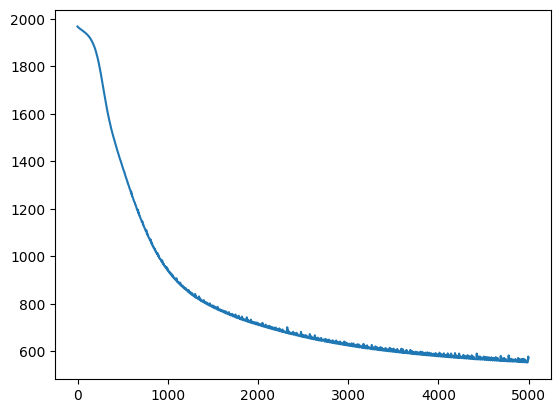

In [107]:
epochs = 5000
losses = []

input_size = len(data)  # Number of previous numbers in the sequence
hidden_size = 64
num_layers = 2
model = LLM(input_size, hidden_size, num_layers)
lossFunction = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(epochs):
    # Forward pass
    predictions = model(inputs)
    loss = lossFunction(predictions, targets)
    loss **= 0.5

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss = loss.item()
    losses.append(loss)
    if loss < 1e2:
        print(f'Early Stopping at Epoch {epoch+1}')
        break

pd.Series(losses).plot()

In [141]:
test_data = [1,2,3,4,5]
test_data = padding(test_data, input_size)
test_input = torch.tensor([test_data], dtype=torch.float32)
predicted_output = model(test_input).item()
predicted_output

903.7752685546875

In [12]:
X_


NameError: name 'pre' is not defined